In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Carregamento arquivo de pré-processamento

In [2]:
%run "/content/drive/My Drive/pre_processamento_TCC.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CPU times: user 3min 33s, sys: 19.7 s, total: 3min 53s
Wall time: 6min 43s
Ataque de exploração UDPLag:  Label
BENIGN       3705
UDP-lag    366461
dtype: int64 

Ataque de exploração Syn:  Label
BENIGN        392
Syn       1582289
dtype: int64 

Ataque de exploração UDP:  Label
BENIGN          2157
DrDoS_UDP    3134645
dtype: int64 

Ataque de exploração LDAP:  Label
BENIGN           1612
DrDoS_LDAP    2179930
dtype: int64 

Ataque de exploração MSSQL:  Label
BENIGN            2006
DrDoS_MSSQL    4522492
dtype: int64 

Ataque de exploração NetBIOS:  Label
BENIGN              1707
DrDoS_NetBIOS    4093279
dtype: int64
Ataque de exploração UDPLag:  Label
0      3705
1    366461
dtype: int64 

Ataque de exploração Syn:  Label
0        392
1    1582289
dtype: int64 

Ataque de exploração UDP:  Label
0       2157
1    3134645
dtype: int64 

Ataque de exploração 

### Bibliotecas


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Divisão do conjunto em treino e teste


In [4]:
netbios

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1,2,0,884.0,0.0,442.0,442.0,442.0,0.0,0.0,0.0,0.0,0.0,8.840000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,442.0,442.0,442.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,663.0,442.0,0.0,-2,0,0,0,0,0,0,2,884,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,2,0,2346.0,0.0,1173.0,1173.0,1173.0,0.0,0.0,0.0,0.0,0.0,2.346000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,1173.0,1173.0,1173.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,1759.5,1173.0,0.0,-2,0,0,0,0,0,0,2,2346,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,2,0,942.0,0.0,471.0,471.0,471.0,0.0,0.0,0.0,0.0,0.0,9.420000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,471.0,471.0,471.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,706.5,471.0,0.0,-2,0,0,0,0,0,0,2,942,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,2,0,1020.0,0.0,510.0,510.0,510.0,0.0,0.0,0.0,0.0,0.0,1.020000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.0,510.0,510.0,510.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,765.0,510.0,0.0,-2,0,0,0,0,0,0,2,1020,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2,2,0,1002.0,0.0,501.0,501.0,501.0,0.0,0.0,0.0,0.0,0.0,5.010000e+08,1.000000e+06,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.0,501.0,501.0,501.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,751.5,501.0,0.0,-2,0,0,0,0,0,0,2,1002,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4094981,2,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,2.290000e+08,1.000000e+06,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,1.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4094982,47,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,9.744681e+06,4.255319e+04,47.0,0.0,47.0,47.0,47.0,47.0,0.0,47.0,47.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,4.255319e+04,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4094983,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458

Preparação dos dados treino e teste


In [5]:
X = netbios.iloc[:, 0:77]
y = netbios.iloc[:,- 1]

70% para treino, 30% para teste

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=42)

In [7]:
# Formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# Tamanho dos conjuntos
print('Amostras de treino: ', x_train.shape[0])
print('Amostras de teste: ', x_test.shape[0])

Formato dos dados de entrada: (2775593, 77)
Amostras de treino:  2775593
Amostras de teste:  1189540


### Seleção dos Parâmetro
Seleção dos 15 melhores parâmetros.

In [8]:
best_features = SelectKBest(score_func=f_classif, k=15)
fit = best_features.fit(x_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train.columns)
# concatenar quadros de dados
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # colunas de saída de nome
print(feature_scores.nlargest(15,'Score'))  # imprima 15 melhores parâmetros

                Feature_Name         Score
47            URG Flag Count  1.483039e+06
50             Down/Up Ratio  1.296542e+06
10     Bwd Packet Length Min  1.069204e+06
29             Fwd PSH Flags  6.457528e+05
44            RST Flag Count  6.457528e+05
53      Avg Bwd Segment Size  4.223726e+05
11    Bwd Packet Length Mean  4.223726e+05
40         Packet Length Std  3.653332e+05
9      Bwd Packet Length Max  3.213644e+05
48            CWE Flag Count  3.115863e+05
2     Total Backward Packets  2.684398e+05
63       Subflow Bwd Packets  2.684398e+05
66   Init_Win_bytes_backward  2.555911e+05
8      Fwd Packet Length Std  2.313388e+05
12     Bwd Packet Length Std  2.031107e+05


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [30 31 32 42 45 49 55 56 57 58 59 60] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [9]:
feature = feature_scores.nlargest(15,'Score')
feature

,Feature_Name,Score
47,URG Flag Count,1.483039e+06
50,Down/Up Ratio,1.296542e+06
10,Bwd Packet Length Min,1.069204e+06
29,Fwd PSH Flags,6.457528e+05
44,RST Flag Count,6.457528e+05
53,Avg Bwd Segment Size,4.223726e+05
11,Bwd Packet Length Mean,4.223726e+05
40,Packet Length Std,3.653332e+05
9,Bwd Packet Length Max,3.213644e+05
48,CWE Flag Count,3.115863e+05


Exlusão dos parâmetros que não seram usados no modelo.


In [10]:
netbios.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

In [11]:
x_train = x_train.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean','Flow Bytes/s',' Flow Packets/s', 
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',' Flow IAT Min', 
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',' Fwd IAT Max', 
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',' Bwd IAT Std', 
       ' Bwd IAT Max', ' Bwd IAT Min',' Bwd PSH Flags', ' Fwd URG Flags', 
       ' Bwd URG Flags',' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Variance','FIN Flag Count', 
       ' SYN Flag Count',' PSH Flag Count', ' ACK Flag Count',' ECE Flag Count',
       ' Average Packet Size', ' Avg Fwd Segment Size',' Fwd Header Length.1', 
       'Fwd Avg Bytes/Bulk',' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', 
       ' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 
       'Subflow Fwd Packets',' Subflow Fwd Bytes', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward',' act_data_pkt_fwd', ' min_seg_size_forward', 
       'Active Mean',' Active Std', ' Active Max', ' Active Min', 'Idle Mean', 
       ' Idle Std',' Idle Max', ' Idle Min'], axis= 1)

x_test = x_test.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean','Flow Bytes/s',' Flow Packets/s', 
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',' Flow IAT Min', 
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',' Fwd IAT Max', 
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',' Bwd IAT Std', 
       ' Bwd IAT Max', ' Bwd IAT Min',' Bwd PSH Flags', ' Fwd URG Flags', 
       ' Bwd URG Flags',' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Variance','FIN Flag Count', 
       ' SYN Flag Count',' PSH Flag Count', ' ACK Flag Count',' ECE Flag Count',
       ' Average Packet Size', ' Avg Fwd Segment Size',' Fwd Header Length.1', 
       'Fwd Avg Bytes/Bulk',' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', 
       ' Bwd Avg Bytes/Bulk',' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 
       'Subflow Fwd Packets',' Subflow Fwd Bytes', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward',' act_data_pkt_fwd', ' min_seg_size_forward', 
       'Active Mean',' Active Std', ' Active Max', ' Active Min', 'Idle Mean', 
       ' Idle Std',' Idle Max', ' Idle Min'], axis= 1)

### Normalização dos dados

In [12]:
normalizador = MinMaxScaler()
x_train= normalizador.fit_transform(x_train)
x_test = normalizador.fit_transform(x_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

### Formatação do tensor em 3D

In [13]:
x_train= x_train.reshape(-1, 2775593, 15)
y_train= y_train.reshape(-1, 2775593, 1)
x_test = x_test.reshape(-1, 1189540, 15)
y_test = y_test.reshape(-1, 1189540, 1)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1, 2775593, 15)
(1, 2775593, 1)
(1, 1189540, 15)
(1, 1189540, 1)


### Rede Neural Recorrente (LSTM)

In [15]:
model1 = Sequential()
model1.add(LSTM(units = 20, return_sequences = True, input_shape=(2775593, 15)))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

# Camada Final
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision'])
# Fit the model
model1.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 87s 87s/step - loss: 0.2500 - accuracy: 0.0270 - auc: 0.5000 - recall: 0.0267 - precision: 0.9936 - val_loss: 0.2437 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 2/50
1/1 [==============================] - 62s 62s/step - loss: 0.2437 - accuracy: 0.9994 - auc: 0.4988 - recall: 0.9998 - precision: 0.9996 - val_loss: 0.2376 - val_accuracy: 0.9996 - val_auc: 0.4958 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 3/50
1/1 [==============================] - 62s 62s/step - loss: 0.2377 - accuracy: 0.9990 - auc: 0.4907 - recall: 0.9995 - precision: 0.9996 - val_loss: 0.2304 - val_accuracy: 0.9996 - val_auc: 0.5001 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 4/50
1/1 [==============================] - 62s 62s/step - loss: 0.2304 - accuracy: 0.9976 - auc: 0.4986 - recall: 0.9980 - precision: 0.9996 - val_loss: 0.2207 - val_accuracy: 0.9996 - val_auc: 0.5004 - val_recall: 1.0000 - val_precis

In [16]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2775593, 20)       2880      
_________________________________________________________________
dropout (Dropout)            (None, 2775593, 20)       0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2775593, 10)       1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2775593, 10)       0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2775593, 10)       840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 2775593, 10)       0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 2775593, 10)       8

In [17]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00557, saving model to model.weights.best.hdf5
1/1 - 49s - loss: 0.0128 - accuracy: 0.9994 - auc: 0.5065 - recall: 0.9998 - precision: 0.9996 - val_loss: 0.0056 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 2/50

Epoch 00002: val_loss improved from 0.00557 to 0.00536, saving model to model.weights.best.hdf5
1/1 - 49s - loss: 0.0125 - accuracy: 0.9994 - auc: 0.4849 - recall: 0.9998 - precision: 0.9996 - val_loss: 0.0054 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 3/50

Epoch 00003: val_loss improved from 0.00536 to 0.00517, saving model to model.weights.best.hdf5
1/1 - 48s - loss: 0.0121 - accuracy: 0.9994 - auc: 0.4960 - recall: 0.9998 - precision: 0.9996 - val_loss: 0.0052 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996
Epoch 4/50

Epoch 00004: val_loss improved from 0.00517 to 0.00499, saving model

In [18]:
scores = model1.evaluate(x_test, y_test, verbose=0)
print('UDPlag')
print("Loss: %.2f%%" % (scores[0]*100))
print("Acurácia: %.2f%%" % (scores[1]*100))
print("AUC: %.2f%%" % (scores[2]*100))
print("Recall: %.2f%%" % (scores[3]*100))
print("Precision: %.2f%%" % (scores[4]*100))

UDPlag
Loss: 0.12%
Acurácia: 99.96%
AUC: 50.00%
Recall: 100.00%
Precision: 99.96%


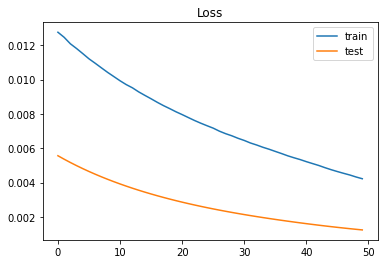

In [19]:
plt.title('Loss')
plt.plot(hist1.history['loss'], label='train')
plt.plot(hist1.history['val_loss'], label='test')
plt.legend()
plt.show();

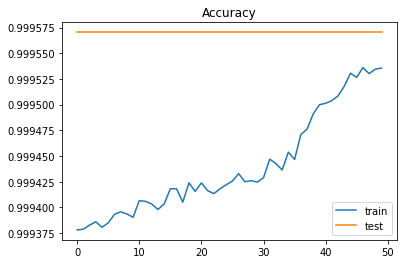

In [20]:
plt.title('Accuracy')
plt.plot(hist1.history['accuracy'], label='train')
plt.plot(hist1.history['val_accuracy'], label='test')
plt.legend()
plt.show();

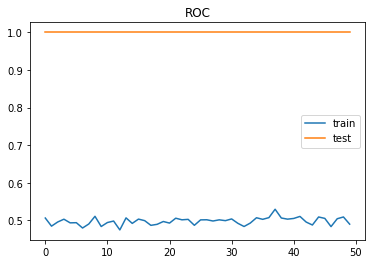

In [21]:
plt.title('ROC')
plt.plot(hist1.history['auc'], label='train')
plt.plot(hist1.history['val_recall'], label='test')
plt.legend()
plt.show();

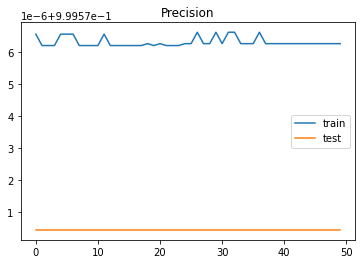

In [22]:
plt.title('Precision')
plt.plot(hist1.history['precision'], label='train')
plt.plot(hist1.history['val_precision'], label='test')
plt.legend()
plt.show();